Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
UMPM


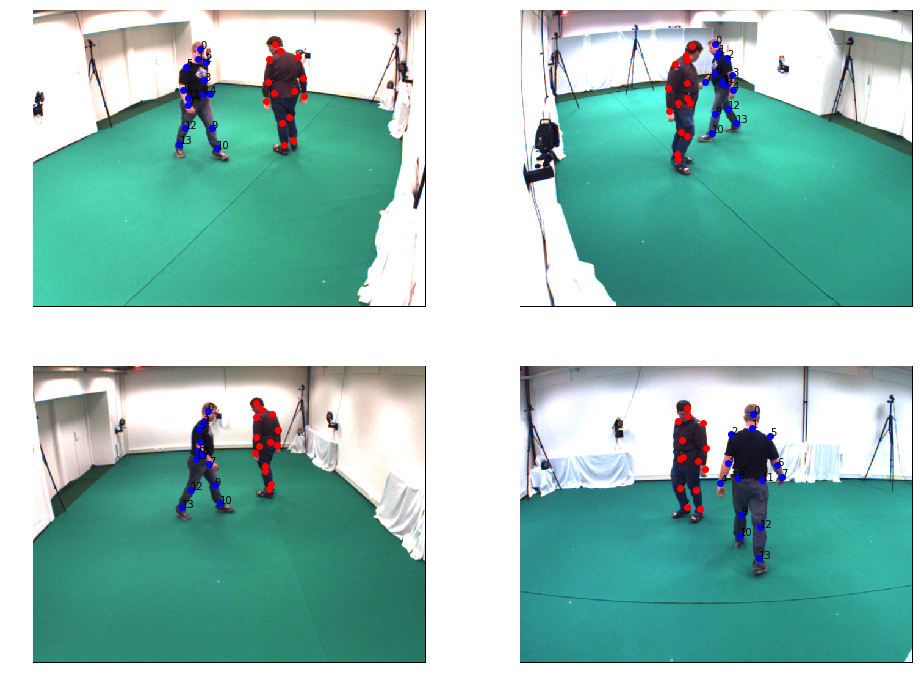

In [1]:
%matplotlib inline
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
sys.path.insert(0, './')
from mvpose.data import umpm
from os.path import join
import numpy as np
from time import time
from openpose import OpenPose

pe = OpenPose(tmp=Settings['tmp'])

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

FRAME = 1430
video = 'p2_free_1'
#FRAME = 0

X, Y, Calib = umpm.get(root, video, user, pwd)
Imgs = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

gt1 = Y[FRAME, 0:14, 0:3].astype('float64')
gt2 = Y[FRAME, 14:, 0:3].astype('float64')

Per1_2d = []
Per1_3d = []

fig = plt.figure(figsize=(16, 12))
for cid, (cam, im) in enumerate(zip(Calib, Imgs)):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.imshow(im)
    ax.axis('off')
    
    gt1_2d = cam.projectPoints(gt1)
    Per1_2d.append(gt1_2d[2:])
    Per1_3d.append(gt1[2:])
    gt2_2d = cam.projectPoints(gt2)
    ax.scatter(gt1_2d[:, 0], gt1_2d[:, 1], color='blue')
    ax.scatter(gt2_2d[:, 0], gt2_2d[:, 1], color='red')
    
    for jid, (x, y) in enumerate(gt1_2d):
        ax.text(x, y, str(jid))
    
plt.show()

extract pose with openpose
	elapsed 0.0005536079406738281


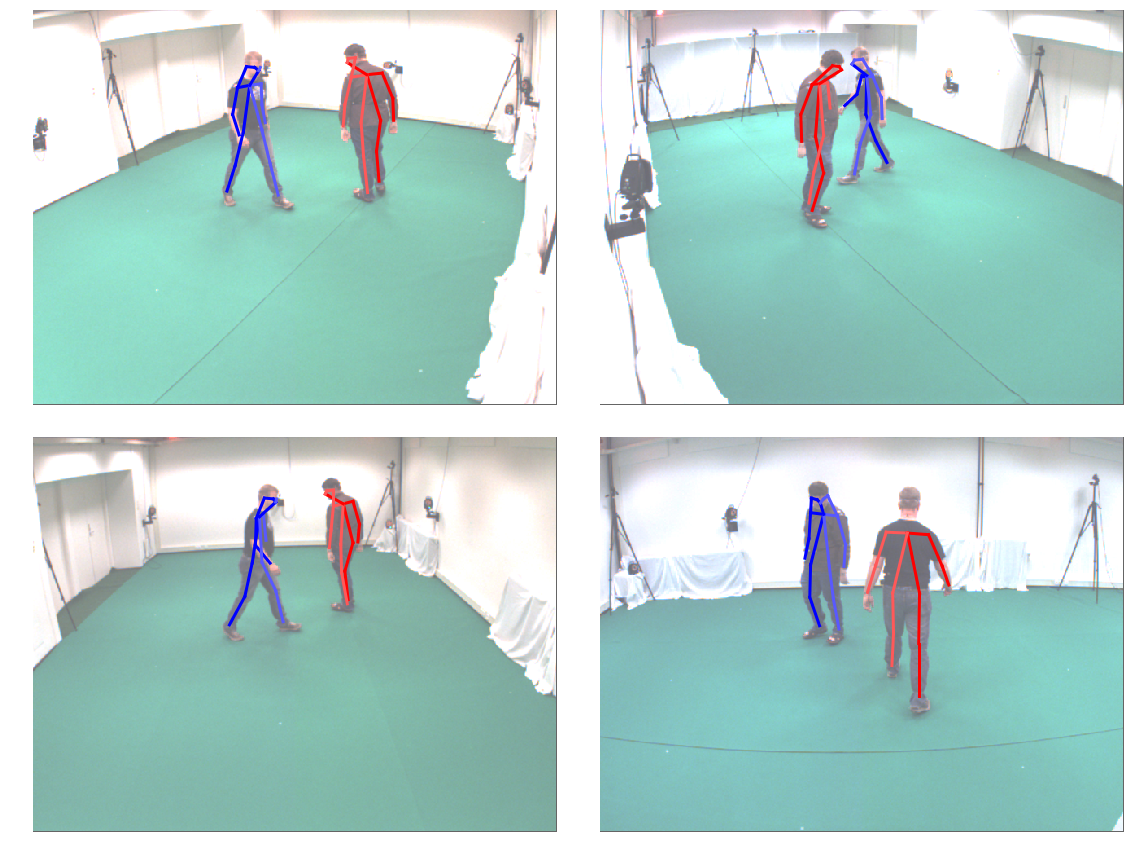

In [2]:
import mvpose.baseline.baseline as bl

print('extract pose with openpose')
_start = time()
positions = pe.predict(Imgs, 'umpm_' + video, FRAME)
_end = time()
print('\telapsed', _end - _start)

from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d

# Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Imgs[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, person in enumerate(positions[idx]):
        draw_mscoco_human2d(ax, person[:, 0:2], 
                            color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [3]:
import mvpose.topdown.projective_optimization as po

positions3d, Hypothesis = bl.estimate(Calib, positions, get_hypothesis=True)
assert len(positions3d) == len(Hypothesis)
n_detections = len(positions3d)

person2d_1_coco = np.array(Hypothesis[0].points)
person2d_1 = po.mscoco_to_headless_umpm_2d(person2d_1_coco)

cids = np.array(Hypothesis[0].debug_2d_ids)[:, 0]

person1_3d = positions3d[0]
person3d = po.mscoco_to_headless_umpm_3d(person1_3d)

Per1_2d = person2d_1
Per1_3d = [person3d] * 4
Per1_3d = np.array(Per1_3d)

print('2d', Per1_2d.shape)
print('3d', Per1_3d.shape)

# remove right food
Per1_3d[:, 11, :] = 0
#Per1_2d[:, 11, :] = 0

2d (4, 12, 3)
3d (4, 12, 3)


In [4]:
# Per1_2d = np.array(Per1_2d)
# Per1_2d = np.pad(Per1_2d, [(0, 0), (0, 0), (0, 1)], 'constant', constant_values=1)
# print('2d', Per1_2d.shape)

# Per1_3d = np.array(Per1_3d)
# print('3d', Per1_3d.shape)

In [5]:
from mvpose.data.base_poses import BasePoses
base_poses = BasePoses('../data/base_poses.txt')

L = base_poses.umpm(gt1)
for lid, s in enumerate(L):
    print((lid, s))

(0, 317.02554)
(1, 200.77211)
(2, 322.17545)
(3, 200.2671)
(4, 436.71298)
(5, 467.09518)
(6, 440.74475)
(7, 469.97607)
(8, 200.57106)
(9, 423.7941)
(10, 556.039)
(11, 541.2377)


In [6]:
X = np.ones((4, 1), np.float32)

Ps = np.array([cam.P.flatten() for cam in Calib])
Per1_2d = Per1_2d.reshape((4, -1))
Per1_3d = Per1_3d.reshape((4, -1))
L_ = np.array([L, L, L, L])
Y = np.concatenate([Ps, Per1_2d, L_], axis=1)

In [7]:
import numpy.linalg as la

# H = HISTORY

def calculate_max_move(pt3d_before, pt3d_after):
    pt3d_before = pt3d_before.reshape((-1, 3))
    pt3d_after = pt3d_after.reshape((-1, 3))
    dif = la.norm(pt3d_before - pt3d_after, axis=1)
    return np.max(dif)
    
# calculate_max_move(H[0], H[1])

In [8]:
from time import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import mvpose.topdown.projective_optimization as po
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf

tf.reset_default_graph()

def optimize(inital_guess3d, Calib, pts2d, L):
    
    repeats = 2
    
    n_cameras = len(Calib)
    X = np.ones((n_cameras * repeats, 1), np.float32)
    
    Ps = np.array([cam.P.flatten() for cam in Calib])
    Ps_ = [Ps] * repeats
    Ps = np.concatenate(Ps_)
    
    L_ = [L] * repeats * n_cameras
    L_ = np.array(L_)
    
    pts2d = pts2d.reshape((4, -1))
    pts2d_ = [pts2d] * repeats
    pts2d = np.concatenate(pts2d_)
    
    print(Ps.shape)
    print(L_.shape)
    print(pts2d.shape)
    
    Y = np.concatenate([Ps, pts2d, L_], axis=1)
    
    print("X", X.shape)
    print("Y", Y.shape)
    
     
    H = [inital_guess3d]
    
    guess3d = inital_guess3d
    
    init_stage = True
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~
    for i in range(10):
        print("step ", i)
        _start = time()
        if i == 0:
            loss, guess3d = run_optimizer(X, Y, 
                                          guess3d, 
                                          learning_rate=100)
        elif i in [1, 2, 3]:
            loss, guess3d = run_optimizer(X, Y, 
                                          guess3d, 
                                          learning_rate=10)
        elif i in [4, 5, 6]:
            loss, guess3d = run_optimizer(X, Y, 
                                          guess3d, 
                                          learning_rate=1)
        else:
            loss, guess3d = run_optimizer(X, Y, 
                                          guess3d, 
                                          learning_rate=.1)
        _end = time()
        H.append(guess3d)
        print("\telapsed", _end - _start)
        print('\tloss', loss)
    
#     for i in range(20):
#         history = model.fit(X, Y, epochs=200, verbose=1)
#         new_points = np.squeeze(o.get_weights()[0])
#         H.append(new_points)
        
#         loss = calculate_max_move(H[-1], H[-2])
#         print("step " + str(i) + ', loss:', loss)
#         if loss < 1:
#             break
        
    return H

def run_optimizer(X, Y, inital_guess3d, learning_rate):
    J = 12
    model = Sequential()
    o = Dense(J * 3, input_shape=(1,), use_bias=False)
    model.add(o)
    
    points_as_w = np.expand_dims(inital_guess3d, axis=0)
    o.set_weights([points_as_w])
    optimizer = SGD(lr=learning_rate)
    
    # --
#     run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#     run_metadata= tf.RunMetadata()
    model.compile(optimizer=optimizer,
                  loss=po.loss_per_cameras,
                  metrics=[po.loss_per_cameras])
    # --
#     from tensorflow.keras.callbacks import TensorBoard
#     tb = TensorBoard(log_dir='./logs')
    
#     model.compile(optimizer=optimizer,
#                   loss=po.loss_per_cameras,
#                   metrics=[po.loss_per_cameras])
    
    
    history = model.fit(X, Y, epochs=200, verbose=0)
    
    
#     from tensorflow.python.client import timeline
#     tl = timeline.Timeline(run_metadata.step_stats)
#     ctf = tl.generate_chrome_trace_format()
#     with open('timeline.json', 'w') as f:
#         f.write(ctf)
    
    
    
    new_points = np.squeeze(o.get_weights()[0])
    return history.history['loss'][-1], new_points
    
    
H = optimize(Per1_3d[0], Calib, Per1_2d, L)

(8, 12)
(8, 12)
(8, 36)
X (8, 1)
Y (8, 60)
step  0
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.cast instead.
	elapsed 27.162126541137695
	loss 14.799375534057617
step  1
	elapsed 27.0183584690094
	loss 6.196399688720703
step  2
	elapsed 27.408916234970093
	loss 5.7764692306518555
step  3
	elapsed 27.432307243347168
	loss 5.974411964416504
step  4
	elapsed 27.462565660476685
	loss 4.9101667404174805
step  5
	elapsed 27.864415407180786
	loss 4.886662483215332
step  6
	elapsed 28.61603617668152
	loss 4.839166164398193
step  7
	elapsed 27.982300281524658
	loss 4.739298343658447
step  8
	elapsed 28.577084064483643
	loss 4.743013858795166
step  9
	elapsed 29.116257905960083
	loss 4.732405662536621


In [9]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# import mvpose.topdown.projective_optimization as po
# from tensorflow.keras.optimizers import Adam, SGD


# def train_run(points3d, learning_rate):
#     J = 12
#     model = Sequential()
#     o = Dense(J * 3, input_shape=(1,), use_bias=False)
#     model.add(o)
#     points_as_w = np.expand_dims(points3d, axis=0)
#     o.set_weights([points_as_w])
#     optimizer = SGD(lr=learning_rate)
#     model.compile(optimizer=optimizer,
#                   loss=po.loss_per_cameras,
#                   metrics=[po.loss_per_cameras])
#     history = model.fit(X, Y, epochs=200, verbose=0)
    
#     new_points = np.squeeze(o.get_weights()[0])
    
#     loss = history.history['loss']
#     dx = loss[0] - loss[-1]
    
#     loss = calculate_max_move(points3d, new_points)
    
#     return dx, new_points, calculate_max_move(points3d, new_points)


# lr = 10
# new_points = Per1_3d[0]

# HISTORY = [new_points.copy()]

# LRs = [100, 10, 1, 0.1]
# Loss_Th = [100, 10, 1, 0.1]

# lr = LRs.pop(0)
# lt = Loss_Th.pop(0)

# for i in range(20):
#     print('iteration ' + str(i) + ', lr=', lr)
#     change, new_points, loss = train_run(new_points, lr)
#     HISTORY.append(new_points.copy())
#     print('\tchange:', change)
#     print('\tloss:', loss)
#     if loss < lt:
#         if len(LRs) == 0:
#             break
#         lr = LRs.pop(0)
#         lt = Loss_Th.pop(0)

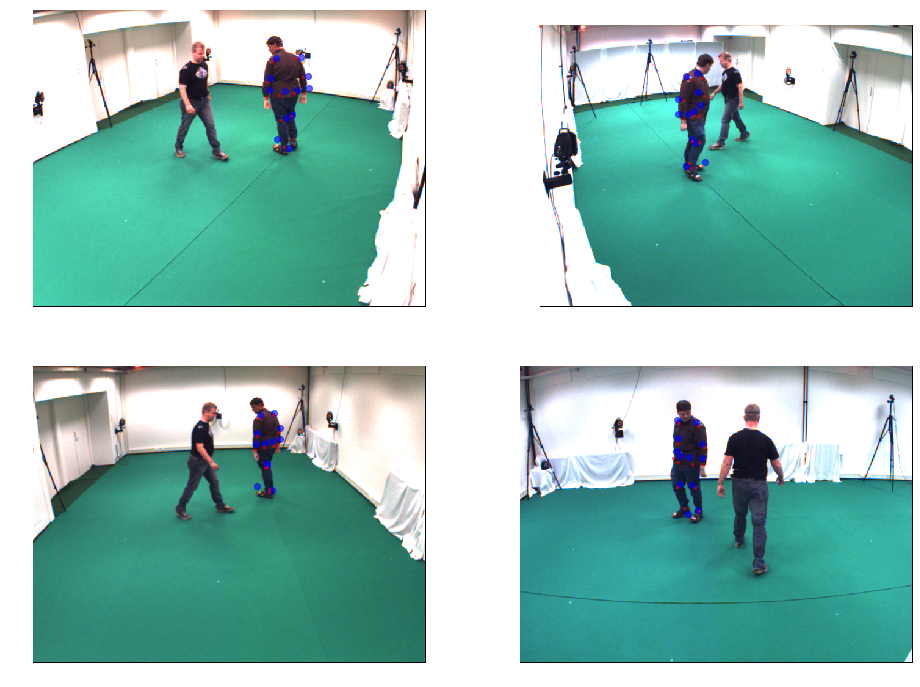

In [10]:
#Pts3d = o.get_weights()[0]
Pts3d = H[-1]

Pts3d_Opti = Pts3d.reshape((-1, 3))

fig = plt.figure(figsize=(16, 12))
for cid, (cam, im) in enumerate(zip(Calib, Imgs)):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.imshow(im)
    ax.axis('off')
    
    pts2d = person2d_1[cid][:, 0:2]
    
    alpha = 0.6
    gt1_optimized = cam.projectPoints(Pts3d_Opti)
    ax.scatter(gt1_optimized[:, 0], gt1_optimized[:, 1], 
               color='blue', alpha=alpha)
    ax.scatter(pts2d[:, 0], pts2d[:, 1], 
               color='red', alpha=0.5, s=5)
    
plt.show()

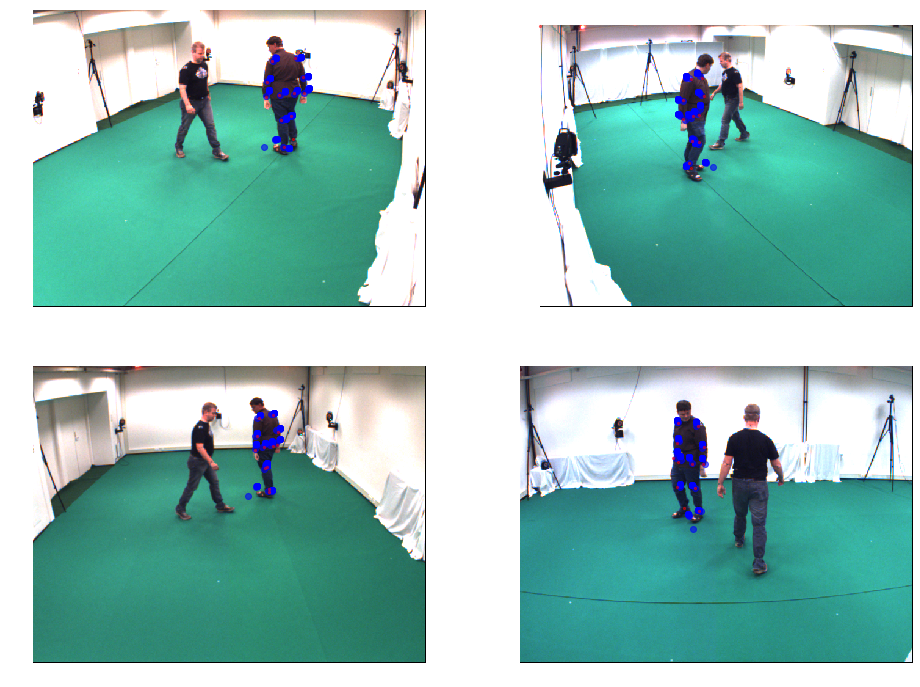

In [11]:
#Pts3d = o.get_weights()[0]
Pts3d = H[-1]

Pts3d_Opti = Pts3d.reshape((-1, 3))
#Pts3d_Orig = points_as_w.reshape((-1, 3))

fig = plt.figure(figsize=(16, 12))
for cid, (cam, im) in enumerate(zip(Calib, Imgs)):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.imshow(im)
    ax.axis('off')
    
    pts2d = person2d_1[cid][:, 0:2]
    
    for hid, pts3d in enumerate(H):
        alpha = (hid+1) / (len(H) + 3)
        alpha = 0.6
        pts3d = pts3d.reshape((-1, 3))
        gt1_optimized = cam.projectPoints(pts3d)
        ax.scatter(gt1_optimized[:, 0], gt1_optimized[:, 1], 
                   color='blue', alpha=alpha)
    ax.scatter(pts2d[:, 0], pts2d[:, 1], 
               color='red', alpha=0.5, s=5)
    
plt.show()


In [12]:
import numpy.linalg as la

def get_L(person):
    umpm_limbs = np.array([
            (2, 3),  # lu arm
            (3, 4),  # ll arm
            (5, 6),  # ru arm
            (6, 7),  # rl arm
            (8, 9),  # lu leg
            (9, 10),  # ll leg
            (11, 12),  # ru leg
            (12, 13),  # rl leg
            (8, 11),  # hip
            (2, 5),  # shoulder
            (2, 8),  # left side
            (5, 11)  # right side
        ]) - 2  # remove first 2 items in UMPM dataset

    L = np.array([
        la.norm(person[a] - person[b]) for (a, b) in umpm_limbs
    ])
    return L
    
L_opt = get_L(Pts3d_Opti)
L_ori = get_L(Pts3d_Orig)
diff = L_opt - L_ori

print("Optimization:\n", L_opt)
print("Original:\n", L_ori)

print('\n\ndiff:\n', diff)

NameError: name 'Pts3d_Orig' is not defined